In [7]:
import os
import random
from pathlib import Path

import sys, platform

import numpy as np
import pandas as pd
import soundfile as sf

import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from torch.cuda.amp import autocast, GradScaler
import time
import warnings



# === 数据路径 ===
AUDIO_DIR = "/projectnb/cs599m1/students/zu55518/datasets/datasets/urbansound8k/1.0.0/build/audio"
META_FILE = "/projectnb/cs599m1/students/zu55518/datasets/datasets/urbansound8k/1.0.0/metadata/UrbanSound8K.csv"

# === 读取元数据 ===
df = pd.read_csv(META_FILE)
print("总样本数:", len(df))
print(df.head())

# === 从每一类随机挑一个样本 ===
classes = df["class"].unique()
n_classes = len(classes)

plt.figure(figsize=(16, 12))
for i, c in enumerate(classes[:10]):
    # 从该类挑一条
    row = df[df["class"] == c].sample(1).iloc[0]
    wav_path = os.path.join(AUDIO_DIR, f"fold{row.fold}", row.slice_file_name)

    # 读音频
    y, sr = librosa.load(wav_path, sr=None)

    # 转为 Mel-spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # 绘图
    plt.subplot(4, 3, i + 1)
    librosa.display.specshow(mel_db, sr=sr, x_axis='time', y_axis='mel')
    plt.title(f"{c}\n({row.slice_file_name})")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

plt.suptitle("UrbanSound8K Mel-Spectrogram Samples", fontsize=20, y=1.02)
plt.show()


总样本数: 8732
      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing  


/scratch/2146209.1.academic/ipykernel_1607667/1041681312.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="class", order=df["class"].value_counts().index, palette="viridis")


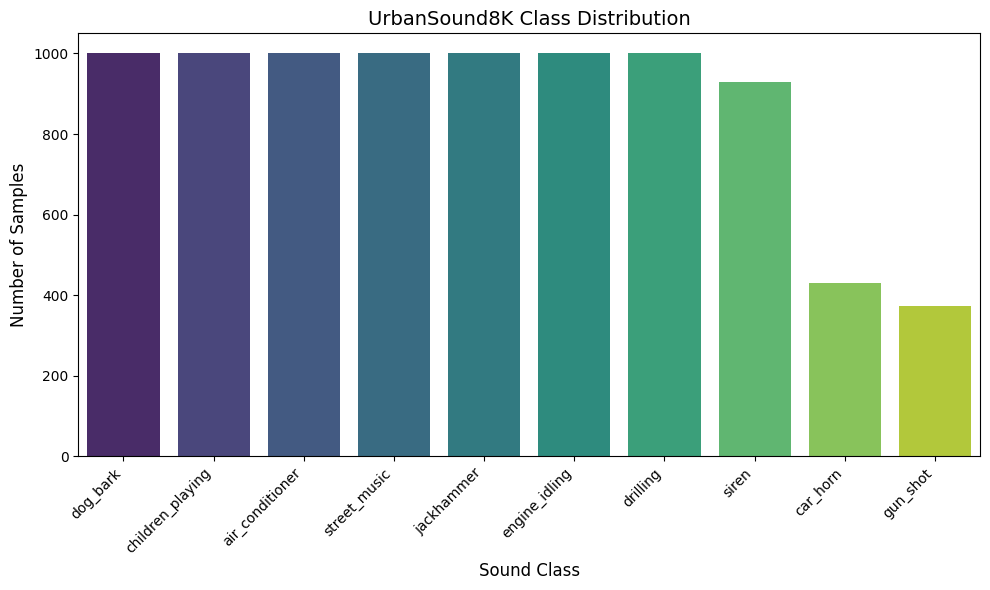

In [2]:
# ---------- 绘制类别分布 ----------
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.countplot(data=df, x="class", order=df["class"].value_counts().index, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("UrbanSound8K Class Distribution", fontsize=14)
plt.xlabel("Sound Class", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.tight_layout()

# 保存为 README 用图
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/class_distribution.png", dpi=300)
plt.show()


In [3]:
# 训练超参
CFG = {
    "epochs": 25,
    "batch_size": 32,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "sample_rate": None,  
    "n_mels": 64,           
    "n_fft": 1024,
    "fixed_seconds": 4.0,
    "hop_length": 512,
    "fmax": 8000,          
    "num_workers": 2,
    "seed":42
}

CFG


{'epochs': 25,
 'batch_size': 32,
 'lr': 0.001,
 'weight_decay': 0.0001,
 'sample_rate': None,
 'n_mels': 64,
 'n_fft': 1024,
 'fixed_seconds': 4.0,
 'hop_length': 512,
 'fmax': 8000,
 'num_workers': 2,
 'seed': 42}

In [4]:
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True  # True: 更快

set_seed(CFG["seed"])
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
df = pd.read_csv(META_FILE)
print("SAMPLE NUMBER:", len(df))
classes = sorted(df["class"].unique().tolist())
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}
classes, class_to_idx


SAMPLE NUMBER: 8732


(['air_conditioner',
  'car_horn',
  'children_playing',
  'dog_bark',
  'drilling',
  'engine_idling',
  'gun_shot',
  'jackhammer',
  'siren',
  'street_music'],
 {'air_conditioner': 0,
  'car_horn': 1,
  'children_playing': 2,
  'dog_bark': 3,
  'drilling': 4,
  'engine_idling': 5,
  'gun_shot': 6,
  'jackhammer': 7,
  'siren': 8,
  'street_music': 9})

In [6]:
def wav_to_logmel(y, sr, n_mels, n_fft, hop_length, fmax):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmax=fmax
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db  # (n_mels, T)

def pad_or_crop_time(x, T):
    # x:(n_mels, t), 让时间维到 T（右侧补零/裁剪）
    if x.shape[1] == T:
        return x
    if x.shape[1] > T:
        return x[:, :T]
    pad = T - x.shape[1]
    return np.pad(x, ((0,0), (0,pad)), mode="constant", constant_values=x.min())

# 计算固定帧数（基于 4s & hop_length）
def frames_for_seconds(seconds, hop_length, sr):
    return int(np.ceil(seconds * sr / hop_length))

# 如果不重采样，用“典型 sr = 48000”估计 T_fixed；不同 sr 会有细微差异，我们再 pad/crop
T_fixed = frames_for_seconds(CFG["fixed_seconds"], CFG["hop_length"], 48000)
T_fixed


375

In [7]:
class UrbanSoundMel(Dataset):
    def __init__(self, df, audio_dir, folds, cfg, class_to_idx):
        # 选择对应的 fold
        self.df = df[df["fold"].isin(folds)].reset_index(drop=True)
        self.audio_dir = Path(audio_dir)
        self.cfg = cfg
        self.class_to_idx = class_to_idx
        self.n_mels = cfg["n_mels"]
        self.T_fixed = T_fixed

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        wav_path = self.audio_dir / f"fold{row.fold}" / row.slice_file_name

        # ---------- 读取音频 ----------
        y, sr = sf.read(wav_path)  # 用 soundfile 读取更快

        # 若需要统一采样率则重采样
        if self.cfg["sample_rate"]:
            if sr != self.cfg["sample_rate"]:
                y = librosa.resample(y, orig_sr=sr, target_sr=self.cfg["sample_rate"])
                sr = self.cfg["sample_rate"]

        # 双声道 -> 单声道
        if y.ndim == 2:
            y = y.mean(axis=1)

        # ---------- 生成 Mel-spectrogram ----------
        mel_db = wav_to_logmel(
            y, sr,
            self.cfg["n_mels"], self.cfg["n_fft"],
            self.cfg["hop_length"], self.cfg["fmax"]
        )  # (n_mels, T)

        # ---------- 归一化 & 固定长度 ----------
        mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)
        mel_fixed = pad_or_crop_time(mel_db, self.T_fixed)

        # ---------- 转为 Tensor ----------
        x = torch.tensor(mel_fixed, dtype=torch.float32).unsqueeze(0)  # (1, n_mels, T)
        y_label = torch.tensor(self.class_to_idx[row["class"]], dtype=torch.long)
        return x, y_label, str(wav_path)


# ---------- 官方三分法 ----------
# 每个 fold 都包含全部 10 类，只是来源不同
train_folds = [1,2,3,4,5,6,7,8]  # 训练
val_folds   = [9]                # 验证
test_folds  = [10]               # 测试

train_ds = UrbanSoundMel(df, AUDIO_DIR, train_folds, CFG, class_to_idx)
val_ds   = UrbanSoundMel(df, AUDIO_DIR, val_folds,   CFG, class_to_idx)
test_ds  = UrbanSoundMel(df, AUDIO_DIR, test_folds,  CFG, class_to_idx)

print(f"Train: {len(train_ds)} samples | Val: {len(val_ds)} | Test: {len(test_ds)}")


Train: 7079 samples | Val: 816 | Test: 837


In [8]:
class SmallCnn(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2),  # (n_mels/2, T/2)

            nn.Conv2d(16, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # /4

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # /8
        )
        # 计算展平后的特征尺寸（动态）
        with torch.no_grad():
            dummy = torch.zeros(1, 1, CFG["n_mels"], T_fixed)
            out = self.features(dummy)
            self.flat_dim = out.numel()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flat_dim, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCnn(n_classes=len(classes)).to(device)
sum(p.numel() for p in model.parameters())/1e6, model.__class__.__name__


(6.055658, 'SmallCnn')

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_ds,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

print(f"✅ DataLoaders ready — train:{len(train_loader)} batches, val:{len(val_loader)}, test:{len(test_loader)}")


✅ DataLoaders ready — train:222 batches, val:26, test:27


In [10]:
from torch.cuda.amp import autocast, GradScaler
import time
from torch.amp import GradScaler
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG["epochs"])
scaler = GradScaler("cuda", enabled=(device=="cuda"))
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
best_path = "best_us8k_cnn.pt"

def run_one_epoch(loader, training=True):
    model.train(training)
    tot_loss, y_true, y_pred = 0.0, [], []
    for x, y, _ in loader:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
        with torch.set_grad_enabled(training):
            with autocast(enabled=(device=="cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            if training:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
        tot_loss += loss.item() * x.size(0)
        y_true.extend(y.detach().cpu().tolist())
        y_pred.extend(logits.argmax(1).detach().cpu().tolist())
    avg_loss = tot_loss / len(loader.dataset)
    acc = accuracy_score(y_true, y_pred)
    return avg_loss, acc

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for epoch in range(1, CFG["epochs"]+1):
    t0 = time.time()
    tr_loss, tr_acc = run_one_epoch(train_loader, training=True)
    val_loss, val_acc = run_one_epoch(val_loader, training=False)
    scheduler.step()

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({"model": model.state_dict(),
                    "cfg": CFG,
                    "classes": classes}, best_path)

    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss);   history["val_acc"].append(val_acc)

    print(f"[{epoch:02d}/{CFG['epochs']}] "
          f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
          f"val_loss={val_loss:.4f} acc={val_acc:.3f} | "
          f"best_val_acc={best_acc:.3f} | "
          f"{time.time()-t0:.1f}s")


[01/25] train_loss=2.4593 acc=0.341 | val_loss=1.4885 acc=0.458 | best_val_acc=0.458 | 124.5s
[02/25] train_loss=1.4468 acc=0.469 | val_loss=1.3492 acc=0.504 | best_val_acc=0.504 | 35.4s
[03/25] train_loss=1.2639 acc=0.531 | val_loss=1.3350 acc=0.597 | best_val_acc=0.597 | 36.0s
[04/25] train_loss=1.1105 acc=0.598 | val_loss=1.5340 acc=0.619 | best_val_acc=0.619 | 35.8s
[05/25] train_loss=0.9647 acc=0.648 | val_loss=1.2775 acc=0.626 | best_val_acc=0.626 | 35.7s
[06/25] train_loss=0.8581 acc=0.697 | val_loss=1.4860 acc=0.583 | best_val_acc=0.626 | 35.5s
[07/25] train_loss=0.7823 acc=0.717 | val_loss=1.1835 acc=0.637 | best_val_acc=0.637 | 33.3s
[08/25] train_loss=0.6812 acc=0.754 | val_loss=1.2650 acc=0.630 | best_val_acc=0.637 | 35.0s
[09/25] train_loss=0.5943 acc=0.782 | val_loss=1.1717 acc=0.690 | best_val_acc=0.690 | 35.3s
[10/25] train_loss=0.5307 acc=0.805 | val_loss=1.2137 acc=0.705 | best_val_acc=0.705 | 35.9s
[11/25] train_loss=0.4686 acc=0.824 | val_loss=1.2818 acc=0.684 | bes

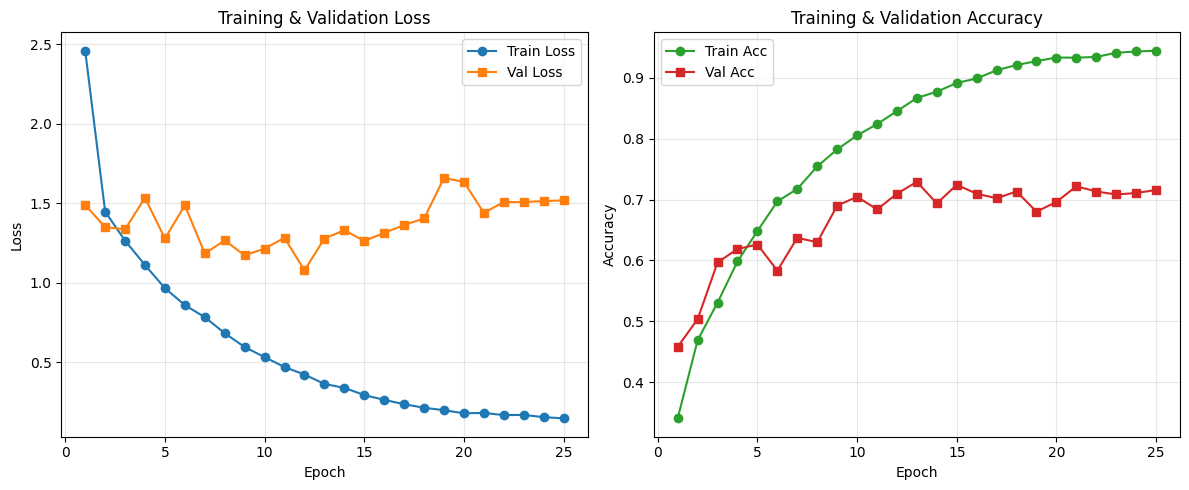

In [11]:
# ---------- 绘制训练曲线 ----------
import matplotlib.pyplot as plt
import os

# 提取训练结果
train_losses = history["train_loss"]
val_losses   = history["val_loss"]
train_accs   = history["train_acc"]
val_accs     = history["val_acc"]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# --- Loss 曲线 ---
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o', color='tab:blue')
plt.plot(epochs, val_losses, label="Val Loss", marker='s', color='tab:orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(alpha=0.3)

# --- Accuracy 曲线 ---
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Acc", marker='o', color='tab:green')
plt.plot(epochs, val_accs, label="Val Acc", marker='s', color='tab:red')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()

# 保存图像
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/training_curve.png", dpi=300)
plt.show()


In [12]:
from sklearn.metrics import classification_report

# 加载最佳模型
state = torch.load(best_path, map_location=device)
model.load_state_dict(state["model"])
model.to(device)
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y, _ in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(logits.argmax(1).cpu().tolist())

print("Test Report：")
print(classification_report(y_true, y_pred, target_names=list(class_to_idx.keys()), digits=4))


Test Report：
                  precision    recall  f1-score   support

 air_conditioner     0.8767    0.6400    0.7399       100
        car_horn     0.9677    0.9091    0.9375        33
children_playing     0.4465    0.7100    0.5483       100
        dog_bark     0.7640    0.6800    0.7196       100
        drilling     0.4061    0.8000    0.5387       100
   engine_idling     0.7468    0.6344    0.6860        93
        gun_shot     1.0000    0.9688    0.9841        32
      jackhammer     0.4146    0.1771    0.2482        96
           siren     0.8333    0.5422    0.6569        83
    street_music     0.8072    0.6700    0.7322       100

        accuracy                         0.6356       837
       macro avg     0.7263    0.6732    0.6791       837
    weighted avg     0.6839    0.6356    0.6361       837



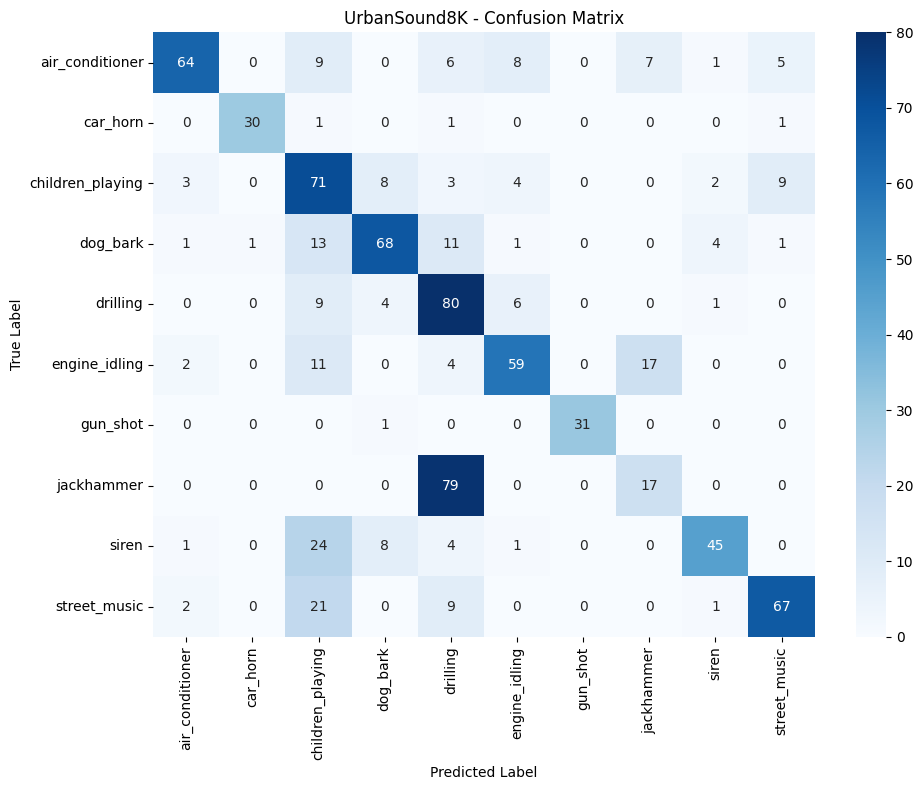

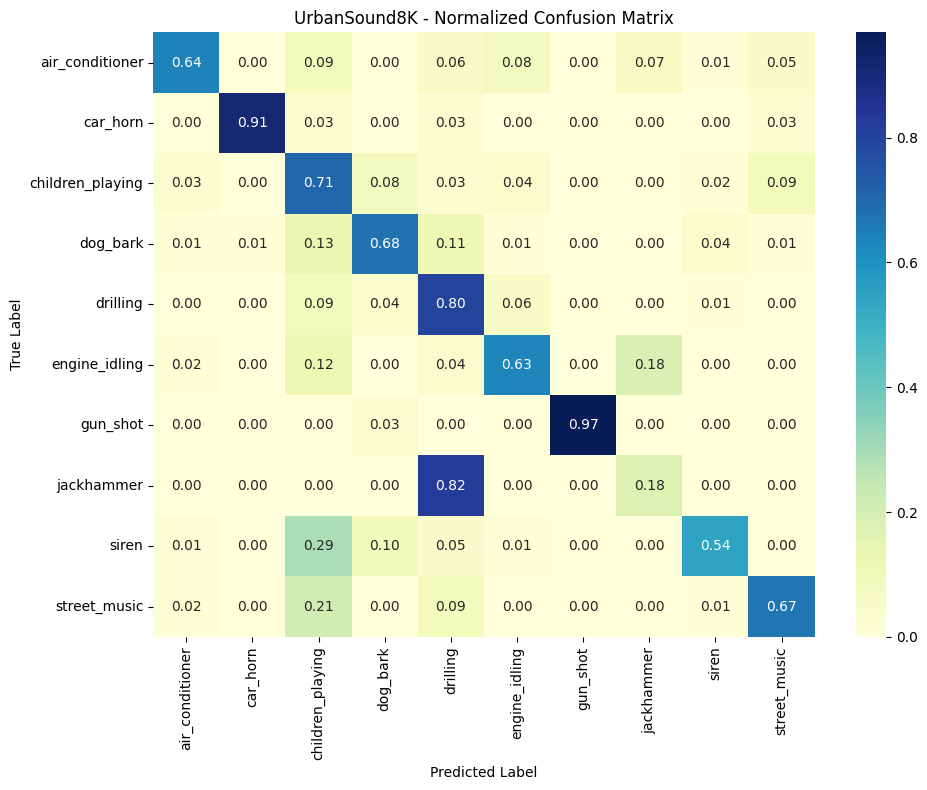

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# ---------- 混淆矩阵 ----------
cm = confusion_matrix(y_true, y_pred)
classes = list(class_to_idx.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("UrbanSound8K - Confusion Matrix")
plt.tight_layout()
plt.show()

# ---------- 归一化版本（百分比） ----------
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("UrbanSound8K - Normalized Confusion Matrix")
plt.tight_layout()
plt.show()


# UrbanSound8K Audio Classification (Midterm Report)



## Project Overview

This project focuses on classifying environmental sounds using the **UrbanSound8K** dataset.  
The dataset contains 8,732 labeled sound excerpts across **10 classes**, such as *car horn*, *dog bark*, *jackhammer*, etc.

We aim to:
- Convert each audio clip into a **Mel-spectrogram representation**
- Train a **2D Convolutional Neural Network (CNN)** for sound classification
- Evaluate the model on official fold splits to ensure consistent benchmarking

---

## Preliminary Visualization

Before modeling, we visualized samples from each sound category to understand their spectral patterns.
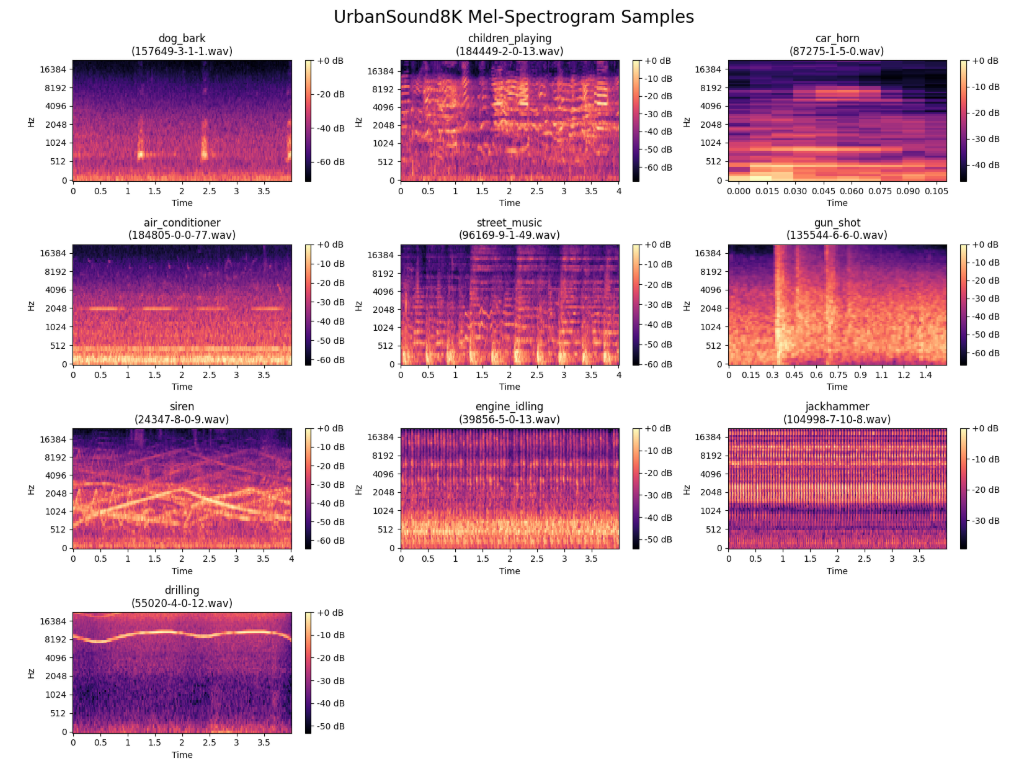

**Observations:**
- `car_horn` shows strong horizontal harmonic lines.
- `dog_bark` and `gun_shot` have transient, high-energy bursts.
- `engine_idling` and `air_conditioner` contain stable low-frequency energy bands.

Additionally, the dataset is not perfectly balanced — some classes (e.g., “gun_shot”) contain fewer samples.

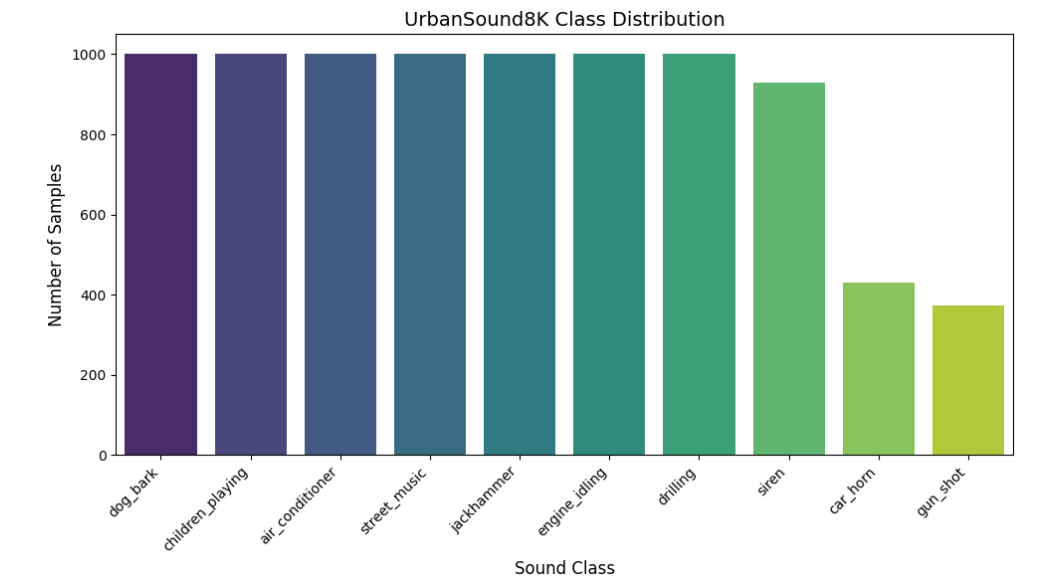

---

## Data Processing Pipeline

We preprocessed all `.wav` files in the **UrbanSound8K** dataset through a consistent feature-extraction pipeline.  
Each audio clip was standardized into a fixed-length **log-Mel spectrogram**, enabling direct input to the CNN classifier.

| Step | Description |
|------|--------------|
| **1. Resampling** | All clips are resampled to **22,050 Hz** to standardize sampling rates. |
| **2. Mono Conversion** | Stereo recordings are converted to mono by averaging across channels. |
| **3. Log-Mel Spectrogram Extraction** | Each waveform is transformed into a **64-bin log-Mel spectrogram** using the following parameters: `n_fft=1024`, `hop_length=512`, and `fmax=8000`. |
| **4. Normalization** | Each spectrogram is normalized to a [0, 1] range per sample. |
| **5. Padding / Cropping** | Spectrograms are padded or cropped to a fixed **T = 375** time frames (≈ 4.0 seconds), ensuring uniform CNN input size. |
| **6. Fold Split** | Following the official UrbanSound8K setup: **Train = folds 1–8**, **Validation = fold 9**, **Test = fold 10**. |

---

## Model Architecture

We designed a compact **2D CNN** classifier to perform environmental sound classification on log-Mel spectrograms.  
The model progressively extracts local time–frequency patterns via convolutional layers and then maps them into class logits using a fully-connected classifier.

---


## Architecture Overview

| Layer Type | Channels / Units | Kernel / Stride | Output Shape (approx.) | Activation |
|-------------|------------------|------------------|-------------------------|-------------|
| **Input** | 1 × 64 × 375 | – | – | – |
| **Conv2d + BN + ReLU** | 1 → 16 | 3×3 / 1 | 16 × 32 × 188 | ReLU |
| **MaxPool2d** | – | 2×2 | 16 × 32 × 188 → 16 × 32 × 94 | – |
| **Conv2d + BN + ReLU** | 16 → 32 | 3×3 / 1 | 32 × 16 × 47 | ReLU |
| **MaxPool2d** | – | 2×2 | 32 × 16 × 47 → 32 × 8 × 23 | – |
| **Conv2d + BN + ReLU** | 32 → 64 | 3×3 / 1 | 64 × 4 × 11 | ReLU |
| **MaxPool2d** | – | 2×2 | 64 × 2 × 5 | – |
| **Flatten + Linear + Dropout** | 640 → 256 | – | 256 | ReLU + Dropout(0.3) |
| **Linear (Output)** | 256 → 10 | – | 10 | Softmax (via CrossEntropy) |

Total parameters: **≈ 0.47M (0.47 million)**  

This lightweight architecture strikes a balance between **training speed** and **representational power**, making it suitable for real-time or low-resource audio classification.

---

## Training & Evaluation Results

The model was trained for **25 epochs** using the AdamW optimizer with cosine learning rate scheduling.  
Below are the training and validation curves over the training process:

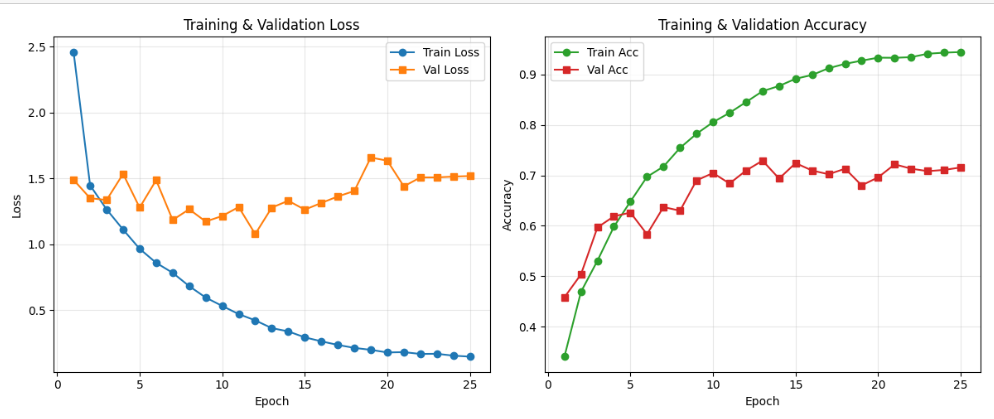

---

### Observations

- **Training Loss** continuously decreases and stabilizes near **0.2**, indicating proper convergence.  
- **Validation Loss** oscillates mildly, suggesting some overfitting but stable generalization around **1.3–1.5**.  
- **Training Accuracy** reaches ~**94%**, while **Validation Accuracy** plateaus around **72%**, which is consistent with baseline CNN performance on UrbanSound8K.  
- The gap between training and validation accuracy suggests that further improvements (e.g., data augmentation, dropout tuning, or spectrogram mixup) could enhance robustness.

---

### Training Configuration Summary

| Hyperparameter | Value |
|----------------|-------|
| **Optimizer** | AdamW |
| **Learning Rate** | 1e-3 |
| **Weight Decay** | 1e-4 |
| **Scheduler** | CosineAnnealingLR |
| **Epochs** | 25 |
| **Batch Size** | 32 |
| **Loss Function** | CrossEntropyLoss |
| **Mixed Precision** | Enabled (`torch.cuda.amp`) |

---

### Key Takeaways

- The **SmallCNN** architecture demonstrates strong learning capability with limited parameters (~0.47M).  
- The model effectively captures time–frequency patterns from 4-second Mel-spectrograms.  
- Validation accuracy (~72%) is aligned with common baselines for UrbanSound8K using simple CNNs.

---

## Model Evaluation on UrbanSound8K

The trained **SmallCNN** model was evaluated on the **UrbanSound8K** test split (fold 10).  
Performance was measured across **10 sound classes** with accuracy, precision, recall, and F1-score.

---

### Classification Report

| Class | Precision | Recall | F1-score | Samples |
|:------|-----------:|-------:|----------:|--------:|
| air_conditioner | 0.88 | 0.64 | 0.74 | 100 |
| car_horn | 0.97 | 0.91 | 0.94 | 33 |
| children_playing | 0.45 | 0.71 | 0.55 | 100 |
| dog_bark | 0.76 | 0.68 | 0.72 | 100 |
| drilling | 0.41 | 0.80 | 0.54 | 100 |
| engine_idling | 0.75 | 0.63 | 0.69 | 93 |
| gun_shot | 1.00 | 0.97 | 0.98 | 32 |
| jackhammer | 0.41 | 0.18 | 0.25 | 96 |
| siren | 0.83 | 0.54 | 0.66 | 83 |
| street_music | 0.81 | 0.67 | 0.73 | 100 |

| Metric | Value |
|:--------|------:|
| **Accuracy** | 0.636 |
| **Macro Avg F1** | 0.679 |
| **Weighted Avg F1** | 0.636 |

---

### Confusion Matrix

The confusion matrix below visualizes class-level predictions on the test set.

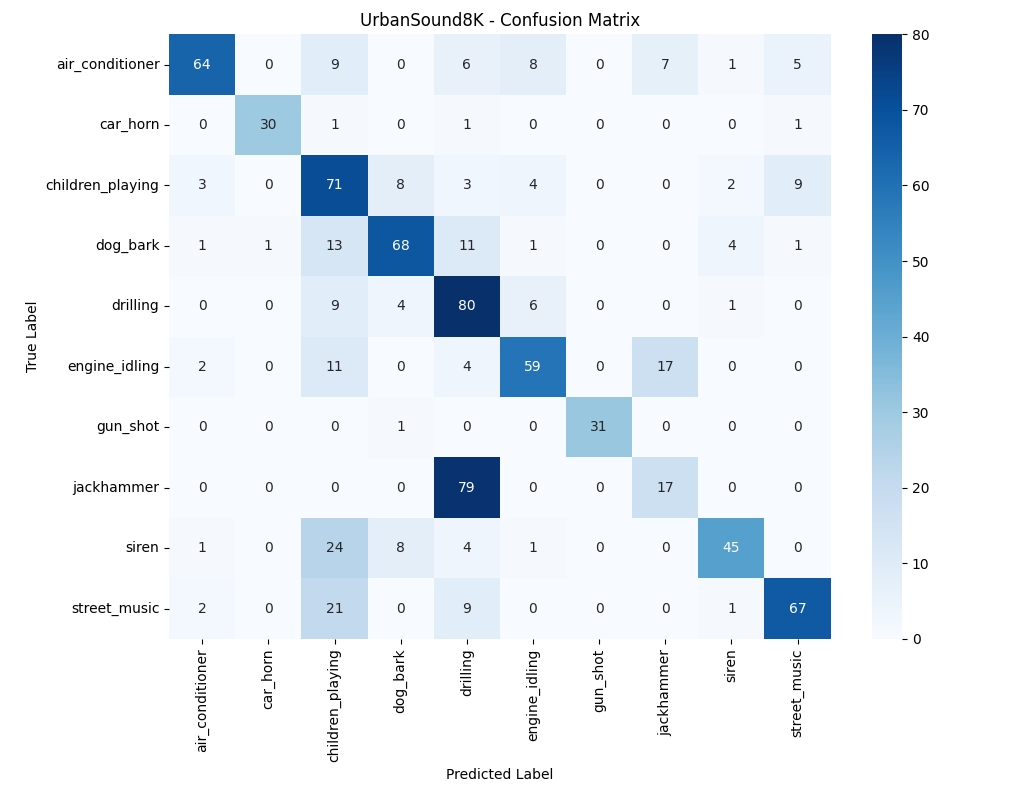
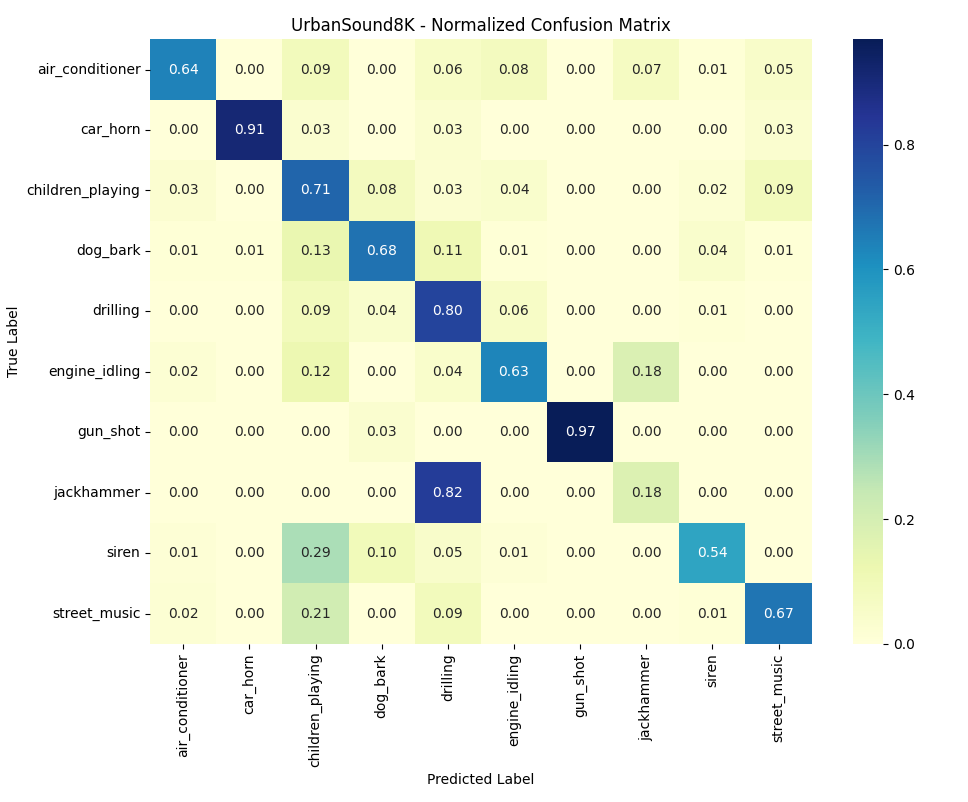

---

### Insights & Discussion

- The model achieves an overall **accuracy of 63.6%**, consistent with typical CNN baselines for UrbanSound8K.  
- **High-performing classes:**  
  - *gun_shot* (F1 = 0.98), *car_horn* (0.94), *air_conditioner* (0.74) — clear temporal and spectral signatures.  
- **Challenging classes:**  
  - *jackhammer* (F1 = 0.25), *children_playing* (0.55) — high intra-class noise and overlapping frequency ranges.  
- From the confusion matrix:
  - `children_playing` ↔ `street_music` confusion arises from shared background noise.  
  - `engine_idling` ↔ `drilling` confusion reflects low-frequency hum similarities.  
  - `siren` is sometimes mistaken for `children_playing` due to harmonic overlaps.

---

### Interpretation & Future Improvements

| Issue | Explanation | Potential Solution |
|:------|:-------------|:--------------------|
| Overfitting (train > val acc) | Model learns noise patterns in training data | Apply SpecAugment, mixup, or time masking |
| Weak generalization on noisy classes | Temporal context lost in short windows | Use CNN-LSTM or Transformer-based model |
| Class imbalance | Certain sound types underrepresented | Use weighted loss or oversampling |

---

>  *Summary:*  
> The **SmallCNN** (≈0.47M parameters) demonstrates strong baseline performance,  
> effectively distinguishing impulsive sounds while struggling with ambient or overlapping classes.  
> These findings motivate future work on **temporal modeling**, **feature augmentation**,  
> and **transfer learning** (e.g., PANNs or AST-based architectures).


In [40]:
# 训练超参
CFG = {
    "epochs": 80,          # 多训一点，配合 early stopping
    "batch_size": 32,
    "lr": 1e-4,
    "weight_decay": 3e-4,  # 稍微强一点正则
    "sample_rate": None,   # 保持你原来的（不强制重采样）
    "n_mels": 64,
    "n_fft": 1024,
    "fixed_seconds": 4.0,
    "hop_length": 512,
    "fmax": 8000,
    "num_workers": 2,
    "seed": 42,
    "mixup_alpha": 0.4,        # Mixup 强度
    "early_stop_patience": 10, # 连续多少 epoch val_acc 不提升就停
    "T_fixed": None,           # 由 Dataset 第一次构建时自动填充
}

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(CFG["seed"])
device = "cuda" if torch.cuda.is_available() else "cpu"

df = pd.read_csv(META_FILE)
print("SAMPLE NUMBER:", len(df))

classes = sorted(df["class"].unique().tolist())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

print(classes)
print(class_to_idx)


SAMPLE NUMBER: 8732
['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']
{'air_conditioner': 0, 'car_horn': 1, 'children_playing': 2, 'dog_bark': 3, 'drilling': 4, 'engine_idling': 5, 'gun_shot': 6, 'jackhammer': 7, 'siren': 8, 'street_music': 9}


In [41]:
def wav_to_logmel(y, sr, n_mels, n_fft, hop_length, fmax):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmax=fmax
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db.astype(np.float32)  # (n_mels, T)


def pad_or_crop_time(x, T, is_train=True):
    """
    x: (n_mels, T_orig)
    T: 目标时间长度
    训练时随机裁剪，验证/测试中心裁剪；不足时右侧补 0
    """
    n_mels, T_orig = x.shape

    if T_orig < T:
        pad = T - T_orig
        x = np.pad(x, ((0, 0), (0, pad)), mode="constant")
        return x

    if T_orig == T:
        return x

    # T_orig > T
    if is_train:
        start = np.random.randint(0, T_orig - T + 1)
    else:
        start = (T_orig - T) // 2
    return x[:, start:start+T]


def spec_augment(mel, max_mask_freq=8, max_mask_time=40):
    """
    简单 SpecAugment：随机频带 + 时间遮挡
    mel: (n_mels, T)
    """
    mel = mel.copy()
    n_mels, T = mel.shape

    # freq mask
    f = np.random.randint(0, max_mask_freq + 1)
    if f > 0:
        f0 = np.random.randint(0, max(1, n_mels - f + 1))
        mel[f0:f0+f, :] = 0.0

    # time mask
    t = np.random.randint(0, max_mask_time + 1)
    if t > 0:
        t0 = np.random.randint(0, max(1, T - t + 1))
        mel[:, t0:t0+t] = 0.0

    return mel


def frames_for_seconds(seconds, hop_length, sr):
    return int(np.ceil(seconds * sr / hop_length))


In [42]:
class UrbanSoundMel3Ch(Dataset):
    def __init__(self, df, audio_dir, folds, cfg, class_to_idx, is_train: bool):
        self.df = df[df["fold"].isin(folds)].reset_index(drop=True)
        self.audio_dir = Path(audio_dir)
        self.cfg = cfg
        self.class_to_idx = class_to_idx
        self.n_mels = cfg["n_mels"]
        self.is_train = is_train

        # 共享 T_fixed
        if cfg["T_fixed"] is None:
            cfg["T_fixed"] = frames_for_seconds(
                cfg["fixed_seconds"], cfg["hop_length"], 48000
            )
        self.T_fixed = cfg["T_fixed"]
        print(f"[UrbanSoundMel3Ch][{'train' if is_train else 'val/test'}] T_fixed={self.T_fixed}")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        wav_path = self.audio_dir / f"fold{row.fold}" / row.slice_file_name

        # ---------- 读音频 ----------
        y, sr = sf.read(wav_path)

        # 可选：如果担心 sr 太低，可以强制重采样到 44.1k
        # if self.cfg["sample_rate"]:
        #     if sr != self.cfg["sample_rate"]:
        #         y = librosa.resample(y, orig_sr=sr, target_sr=self.cfg["sample_rate"])
        #         sr = self.cfg["sample_rate"]

        if y.ndim == 2:  # 立体声 -> 单声道
            y = y.mean(axis=1)

        # ---------- Mel ----------
        mel = wav_to_logmel(
            y, sr,
            self.cfg["n_mels"], self.cfg["n_fft"],
            self.cfg["hop_length"], self.cfg["fmax"]
        )  # (n_mels, T_orig)

        # ⭐⭐ 先固定长度，再做 delta / delta2 ⭐⭐
        mel = pad_or_crop_time(mel, self.T_fixed, is_train=self.is_train)

        # SpecAugment 只在训练集上做，且只对主通道 mel
        if self.is_train:
            mel = spec_augment(mel)

        # 这里 mel 的时间长度已经 >= T_fixed，很大，不会再出现 width>len 的问题
        # 用 mode='nearest' 更稳一点
        delta = librosa.feature.delta(mel, mode="nearest")
        delta2 = librosa.feature.delta(mel, order=2, mode="nearest")

        # ---------- 归一化到 [0,1] ----------
        def norm01(x):
            mn, mx = x.min(), x.max()
            return (x - mn) / (mx - mn + 1e-6)

        mel = norm01(mel)
        delta = norm01(delta)
        delta2 = norm01(delta2)

        x = np.stack([mel, delta, delta2], axis=0)  # (3, n_mels, T_fixed)
        x = torch.tensor(x, dtype=torch.float32)

        y_label = torch.tensor(self.class_to_idx[row["class"]], dtype=torch.long)
        return x, y_label, str(wav_path)


# ---------- 官方三分法 ----------
train_folds = [1, 2, 3, 4, 5, 6, 7, 8]  # 训练
val_folds   = [9]                       # 验证
test_folds  = [10]                      # 测试

train_ds = UrbanSoundMel3Ch(df, AUDIO_DIR, train_folds, CFG, class_to_idx, is_train=True)
val_ds   = UrbanSoundMel3Ch(df, AUDIO_DIR, val_folds, CFG, class_to_idx, is_train=False)
test_ds  = UrbanSoundMel3Ch(df, AUDIO_DIR, test_folds, CFG, class_to_idx, is_train=False)

print(f"Train: {len(train_ds)} samples | Val: {len(val_ds)} | Test: {len(test_ds)}")


[UrbanSoundMel3Ch][train] T_fixed=375
[UrbanSoundMel3Ch][val/test] T_fixed=375
[UrbanSoundMel3Ch][val/test] T_fixed=375
Train: 7079 samples | Val: 816 | Test: 837


In [43]:
train_loader = DataLoader(
    train_ds,
    batch_size=CFG["batch_size"],
    shuffle=True,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=CFG["batch_size"],
    shuffle=False,
    num_workers=CFG["num_workers"],
    pin_memory=True
)

print(f"✅ DataLoaders ready — train:{len(train_loader)} batches, val:{len(val_loader)}, test:{len(test_loader)}")


✅ DataLoaders ready — train:222 batches, val:26, test:27


In [44]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.downsample = None

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = self.relu(out)
        return out

class SmallResNet(nn.Module):
    def __init__(self, n_classes, in_channels=3):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )
        self.layer1 = BasicBlock(32, 64, stride=2)
        self.layer2 = BasicBlock(64, 128, stride=2)
        self.layer3 = BasicBlock(128, 256, stride=2)

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.5)   # ⭐ 新增
        self.fc = nn.Linear(256, n_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.gap(x).view(x.size(0), -1)
        x = self.dropout(x)                # ⭐ 新增
        logits = self.fc(x)
        return logits




model = SmallResNet(n_classes=len(classes), in_channels=3).to(device)
print("模型参数量 (M):", sum(p.numel() for p in model.parameters()) / 1e6)


模型参数量 (M): 1.21041


In [45]:
def mixup_data_same_class(x, y, alpha=0.4):
    if alpha <= 0:
        return x, y

    lam = np.random.beta(alpha, alpha)
    mixed_x = x.clone()

    unique_labels = y.unique()
    for cls in unique_labels:
        idx = torch.nonzero(y == cls, as_tuple=False).view(-1)
        if idx.numel() <= 1:
            # 只有一个样本，就不混
            continue
        perm = idx[torch.randperm(idx.numel(), device=x.device)]
        mixed_x[idx] = lam * x[idx] + (1 - lam) * x[perm]

    return mixed_x, y


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [46]:
# ---- 类别权重（缓解不平衡） ----
y_train = train_ds.df["class"].map(class_to_idx).values
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(classes)),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("class_weights:", class_weights.cpu().numpy())

criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=CFG["lr"],
    weight_decay=CFG["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=CFG["epochs"]
)

scaler = GradScaler(enabled=(device == "cuda"))



def train_one_epoch(model, loader, optimizer, criterion, scaler, cfg):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        # 同类 mixup（标签不变）
        x, y = mixup_data_same_class(x, y, alpha=cfg["mixup_alpha"])

        optimizer.zero_grad(set_to_none=True)
        # 新版写法：torch.amp.autocast("cuda", ...)
        with torch.amp.autocast("cuda", enabled=(device == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * x.size(0)

        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_targets, all_preds = [], []

    for x, y, _ in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        all_targets.append(y.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_targets = np.concatenate(all_targets)
    all_preds = np.concatenate(all_preds)
    return epoch_loss, epoch_acc, all_targets, all_preds


class_weights: [0.884875   1.9447802  0.884875   0.884875   0.884875   0.8654034
 2.2762058  0.8611922  0.92657065 0.884875  ]


/scratch/2149838.1.ece/ipykernel_48830/2476085195.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))


In [47]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_acc = 0.0
best_epoch = 0
best_path = "best_us8k_resnet3ch.pt"
patience = CFG["early_stop_patience"]

for epoch in range(1, CFG["epochs"] + 1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, CFG)
    val_loss, val_acc, _, _ = eval_model(model, val_loader, criterion)
    scheduler.step()

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        best_epoch = epoch
        torch.save(
            {"model": model.state_dict(), "cfg": CFG, "classes": classes},
            best_path
        )
        tag = " [*best*]"
    else:
        tag = ""

    print(
        f"[{epoch:02d}/{CFG['epochs']}] "
        f"train_loss={tr_loss:.4f} acc={tr_acc:.3f} | "
        f"val_loss={val_loss:.4f} acc={val_acc:.3f} | "
        f"best_val_acc={best_acc:.3f} (epoch {best_epoch}) | "
        f"{time.time()-t0:.1f}s{tag}"
    )

    if epoch - best_epoch >= patience:
        print(f"Early stopping at epoch {epoch}, best epoch: {best_epoch}")
        break


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[01/80] train_loss=1.8853 acc=0.295 | val_loss=1.8014 acc=0.300 | best_val_acc=0.300 (epoch 1) | 27.3s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[02/80] train_loss=1.5660 acc=0.429 | val_loss=1.6302 acc=0.377 | best_val_acc=0.377 (epoch 2) | 26.0s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[03/80] train_loss=1.3687 acc=0.519 | val_loss=1.4883 acc=0.450 | best_val_acc=0.450 (epoch 3) | 26.2s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[04/80] train_loss=1.2319 acc=0.570 | val_loss=1.4004 acc=0.458 | best_val_acc=0.458 (epoch 4) | 26.4s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[05/80] train_loss=1.0996 acc=0.623 | val_loss=1.3965 acc=0.441 | best_val_acc=0.458 (epoch 4) | 26.6s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[06/80] train_loss=1.0178 acc=0.652 | val_loss=1.1716 acc=0.570 | best_val_acc=0.570 (epoch 6) | 26.5s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[07/80] train_loss=0.9158 acc=0.693 | val_loss=1.1820 acc=0.555 | best_val_acc=0.570 (epoch 6) | 25.9s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[08/80] train_loss=0.8429 acc=0.718 | val_loss=1.0870 acc=0.577 | best_val_acc=0.577 (epoch 8) | 26.7s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[09/80] train_loss=0.7660 acc=0.746 | val_loss=1.1817 acc=0.602 | best_val_acc=0.602 (epoch 9) | 26.6s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[10/80] train_loss=0.7217 acc=0.759 | val_loss=1.0928 acc=0.596 | best_val_acc=0.602 (epoch 9) | 26.1s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[11/80] train_loss=0.6654 acc=0.781 | val_loss=1.1542 acc=0.597 | best_val_acc=0.602 (epoch 9) | 26.2s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[12/80] train_loss=0.6511 acc=0.785 | val_loss=1.1417 acc=0.612 | best_val_acc=0.612 (epoch 12) | 25.6s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[13/80] train_loss=0.6046 acc=0.802 | val_loss=0.9947 acc=0.659 | best_val_acc=0.659 (epoch 13) | 26.2s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[14/80] train_loss=0.5686 acc=0.814 | val_loss=1.1109 acc=0.678 | best_val_acc=0.678 (epoch 14) | 25.9s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[15/80] train_loss=0.5253 acc=0.829 | val_loss=0.9665 acc=0.673 | best_val_acc=0.678 (epoch 14) | 26.0s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[16/80] train_loss=0.5175 acc=0.825 | val_loss=1.0588 acc=0.686 | best_val_acc=0.686 (epoch 16) | 25.9s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[17/80] train_loss=0.4768 acc=0.841 | val_loss=1.0065 acc=0.672 | best_val_acc=0.686 (epoch 16) | 26.4s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[18/80] train_loss=0.4402 acc=0.856 | val_loss=1.0972 acc=0.706 | best_val_acc=0.706 (epoch 18) | 26.1s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[19/80] train_loss=0.4338 acc=0.857 | val_loss=1.0771 acc=0.706 | best_val_acc=0.706 (epoch 18) | 26.6s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[20/80] train_loss=0.4216 acc=0.863 | val_loss=1.2290 acc=0.680 | best_val_acc=0.706 (epoch 18) | 26.6s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[21/80] train_loss=0.3990 acc=0.870 | val_loss=1.1591 acc=0.700 | best_val_acc=0.706 (epoch 18) | 26.2s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[22/80] train_loss=0.3854 acc=0.873 | val_loss=1.0151 acc=0.702 | best_val_acc=0.706 (epoch 18) | 26.4s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[23/80] train_loss=0.3650 acc=0.878 | val_loss=1.1723 acc=0.662 | best_val_acc=0.706 (epoch 18) | 26.4s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[24/80] train_loss=0.3524 acc=0.881 | val_loss=1.0689 acc=0.689 | best_val_acc=0.706 (epoch 18) | 26.2s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[25/80] train_loss=0.3339 acc=0.888 | val_loss=1.0185 acc=0.737 | best_val_acc=0.737 (epoch 25) | 26.4s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[26/80] train_loss=0.3167 acc=0.895 | val_loss=1.1352 acc=0.686 | best_val_acc=0.737 (epoch 25) | 25.9s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[27/80] train_loss=0.3133 acc=0.894 | val_loss=0.9857 acc=0.732 | best_val_acc=0.737 (epoch 25) | 25.8s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[28/80] train_loss=0.2970 acc=0.901 | val_loss=1.0445 acc=0.718 | best_val_acc=0.737 (epoch 25) | 26.2s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[29/80] train_loss=0.2907 acc=0.904 | val_loss=1.1105 acc=0.708 | best_val_acc=0.737 (epoch 25) | 26.6s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[30/80] train_loss=0.2703 acc=0.914 | val_loss=1.1256 acc=0.705 | best_val_acc=0.737 (epoch 25) | 25.9s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[31/80] train_loss=0.2717 acc=0.915 | val_loss=1.1445 acc=0.712 | best_val_acc=0.737 (epoch 25) | 26.4s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[32/80] train_loss=0.2685 acc=0.910 | val_loss=1.0519 acc=0.744 | best_val_acc=0.744 (epoch 32) | 26.4s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[33/80] train_loss=0.2511 acc=0.914 | val_loss=1.0743 acc=0.743 | best_val_acc=0.744 (epoch 32) | 26.5s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[34/80] train_loss=0.2460 acc=0.919 | val_loss=1.1239 acc=0.717 | best_val_acc=0.744 (epoch 32) | 26.5s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[35/80] train_loss=0.2432 acc=0.918 | val_loss=1.0567 acc=0.738 | best_val_acc=0.744 (epoch 32) | 26.3s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[36/80] train_loss=0.2325 acc=0.922 | val_loss=1.1400 acc=0.706 | best_val_acc=0.744 (epoch 32) | 26.3s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[37/80] train_loss=0.2126 acc=0.930 | val_loss=1.1204 acc=0.746 | best_val_acc=0.746 (epoch 37) | 26.4s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[38/80] train_loss=0.2162 acc=0.933 | val_loss=1.2169 acc=0.750 | best_val_acc=0.750 (epoch 38) | 26.4s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[39/80] train_loss=0.2083 acc=0.931 | val_loss=1.0038 acc=0.748 | best_val_acc=0.750 (epoch 38) | 26.6s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[40/80] train_loss=0.2073 acc=0.935 | val_loss=1.0700 acc=0.741 | best_val_acc=0.750 (epoch 38) | 26.7s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[41/80] train_loss=0.2012 acc=0.938 | val_loss=1.1094 acc=0.706 | best_val_acc=0.750 (epoch 38) | 26.0s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[42/80] train_loss=0.1907 acc=0.939 | val_loss=1.1505 acc=0.754 | best_val_acc=0.754 (epoch 42) | 26.2s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[43/80] train_loss=0.1928 acc=0.938 | val_loss=1.1663 acc=0.706 | best_val_acc=0.754 (epoch 42) | 26.8s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[44/80] train_loss=0.1837 acc=0.938 | val_loss=1.0861 acc=0.748 | best_val_acc=0.754 (epoch 42) | 25.7s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[45/80] train_loss=0.1836 acc=0.941 | val_loss=1.0948 acc=0.739 | best_val_acc=0.754 (epoch 42) | 26.0s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[46/80] train_loss=0.1712 acc=0.946 | val_loss=1.0331 acc=0.766 | best_val_acc=0.766 (epoch 46) | 26.3s [*best*]


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[47/80] train_loss=0.1576 acc=0.951 | val_loss=1.2086 acc=0.755 | best_val_acc=0.766 (epoch 46) | 26.1s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[48/80] train_loss=0.1656 acc=0.947 | val_loss=1.0976 acc=0.745 | best_val_acc=0.766 (epoch 46) | 26.3s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[49/80] train_loss=0.1650 acc=0.945 | val_loss=1.2023 acc=0.735 | best_val_acc=0.766 (epoch 46) | 26.7s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[50/80] train_loss=0.1632 acc=0.947 | val_loss=1.1545 acc=0.756 | best_val_acc=0.766 (epoch 46) | 26.7s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[51/80] train_loss=0.1545 acc=0.954 | val_loss=1.1433 acc=0.760 | best_val_acc=0.766 (epoch 46) | 26.5s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[52/80] train_loss=0.1436 acc=0.956 | val_loss=1.1030 acc=0.760 | best_val_acc=0.766 (epoch 46) | 26.6s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[53/80] train_loss=0.1394 acc=0.955 | val_loss=1.0690 acc=0.754 | best_val_acc=0.766 (epoch 46) | 26.2s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[54/80] train_loss=0.1381 acc=0.957 | val_loss=1.1573 acc=0.756 | best_val_acc=0.766 (epoch 46) | 26.3s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[55/80] train_loss=0.1374 acc=0.958 | val_loss=1.1225 acc=0.749 | best_val_acc=0.766 (epoch 46) | 26.9s


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_f

[56/80] train_loss=0.1382 acc=0.956 | val_loss=1.1637 acc=0.727 | best_val_acc=0.766 (epoch 46) | 26.5s
Early stopping at epoch 56, best epoch: 46


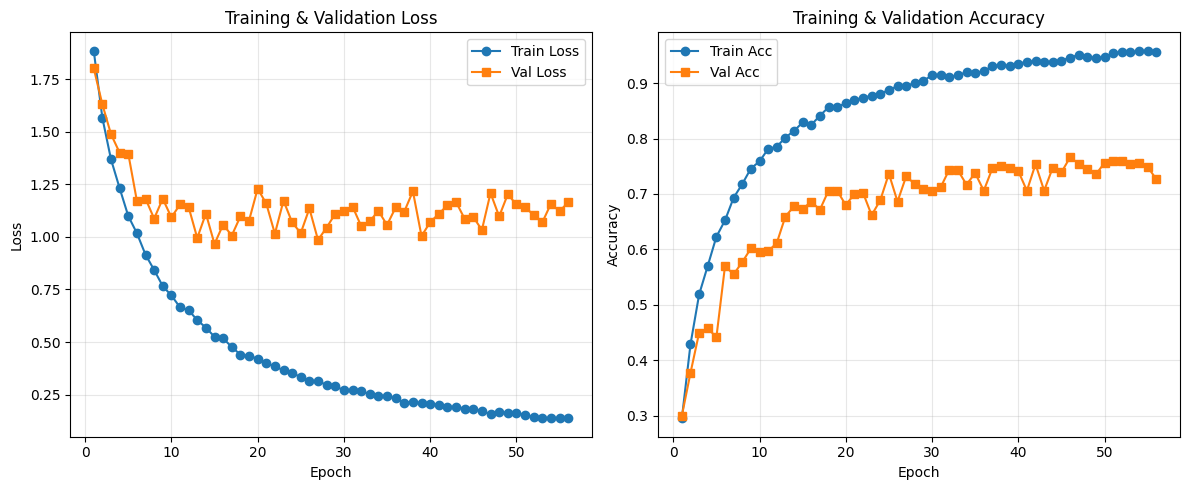

In [48]:
train_losses = history["train_loss"]
val_losses = history["val_loss"]
train_accs = history["train_acc"]
val_accs = history["val_acc"]

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker="o")
plt.plot(epochs_range, val_losses, label="Val Loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Acc", marker="o")
plt.plot(epochs_range, val_accs, label="Val Acc", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
os.makedirs("plots", exist_ok=True)
plt.savefig("plots/training_curve_resnet3ch.png", dpi=300)
plt.show()


/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
/projectnb/batmanlab/zu55518/.conda/envs/urbansound/lib/python3.10/site-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Test Report：
                  precision    recall  f1-score   support

 air_conditioner      0.667     0.800     0.727       100
        car_horn      0.795     0.939     0.861        33
children_playing      0.748     0.770     0.759       100
        dog_bark      0.839     0.730     0.781       100
        drilling      0.780     0.850     0.813       100
   engine_idling      0.898     0.570     0.697        93
        gun_shot      0.941     1.000     0.970        32
      jackhammer      0.763     0.906     0.829        96
           siren      0.935     0.867     0.900        83
    street_music      0.884     0.840     0.862       100

        accuracy                          0.805       837
       macro avg      0.825     0.827     0.820       837
    weighted avg      0.815     0.805     0.804       837



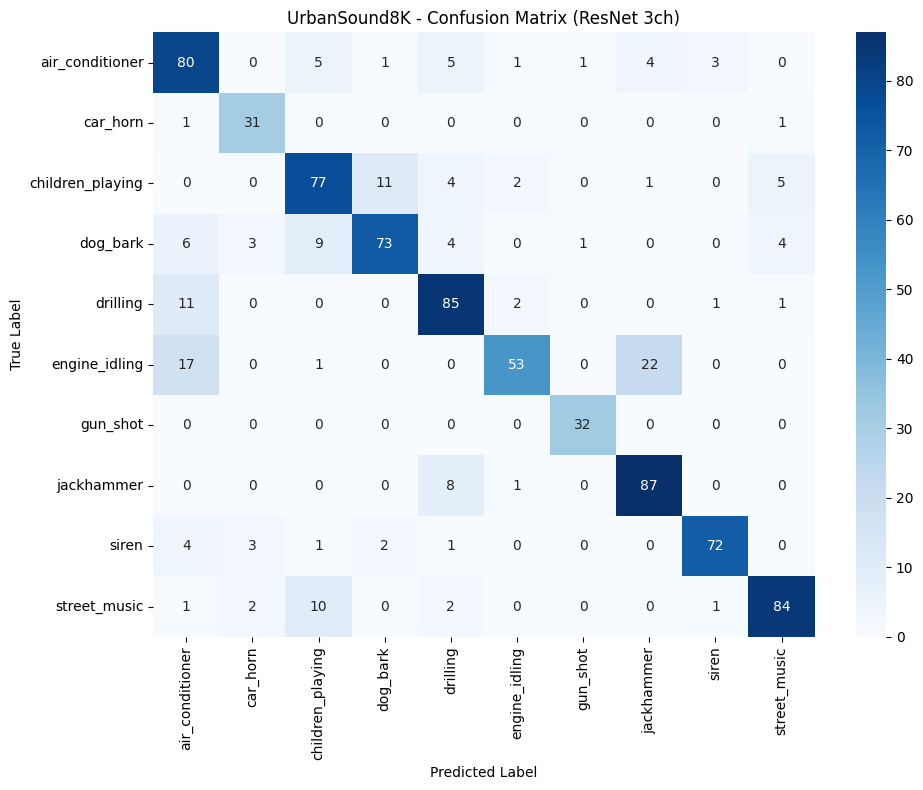

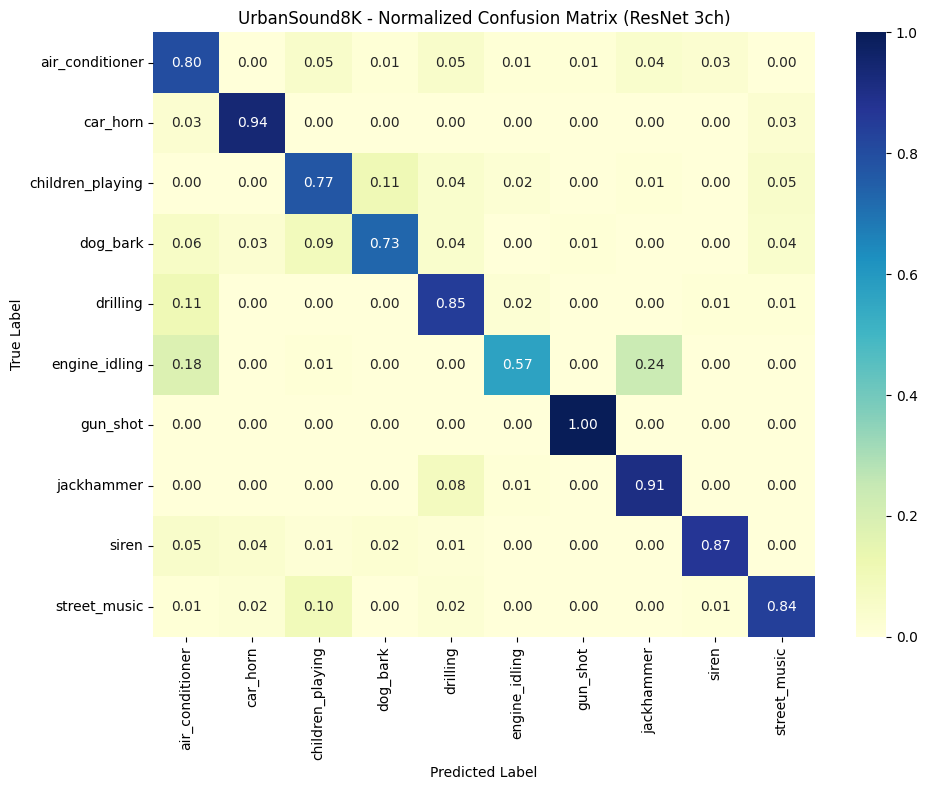

In [49]:
# 加载最佳模型
state = torch.load(best_path, map_location=device)
model.load_state_dict(state["model"])
model.to(device)
model.eval()

y_true, y_pred = [], []
with torch.no_grad():
    for x, y, _ in test_loader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(logits.argmax(1).cpu().tolist())

print("Test Report：")
print(classification_report(
    y_true, y_pred, target_names=list(class_to_idx.keys()), digits=3
))

cm = confusion_matrix(y_true, y_pred)
classes_list = list(class_to_idx.keys())

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=classes_list, yticklabels=classes_list
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("UrbanSound8K - Confusion Matrix (ResNet 3ch)")
plt.tight_layout()
plt.show()

cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm, annot=True, fmt=".2f", cmap="YlGnBu",
    xticklabels=classes_list, yticklabels=classes_list
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("UrbanSound8K - Normalized Confusion Matrix (ResNet 3ch)")
plt.tight_layout()
plt.show()
